**J. Behler and M. Parrinello, Generalized Neural-Network Representation of High-Dimensional Potential-Energy Surfaces, PRL 98, 146401 (2007)**

In [1]:
from math import exp, pow, sqrt, tanh, pi, cos, ceil
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
import numpy as np
np.set_printoptions(threshold=np.inf)
import random
from pytorch_lightning import loggers as pl_loggers
torch.set_printoptions(threshold=np.inf)
from sklearn.model_selection import train_test_split

In [17]:
#Require Input
Num_atom = 14  # QM area
Num_atom_all = 6041 # QM and MM area
Num_atom_all = 14 # QM and MM area
Num_config = 20 #Number of snapshots

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

Num_train = int(Num_config * train_ratio) # Number of training set
Num_valid = int(Num_config * validation_ratio) # Number of valid set
Num_test = Num_config -  Num_train - Num_valid #Number of test set

element_list = ['C', 'C', 'H', 'H', 'H', 'C', 'H', 'H', 'O', 'C', 'C', 'H', 'H', 'H']

charge_of_water = [-0.834, 0.417, 0.417] # TIP3P Water


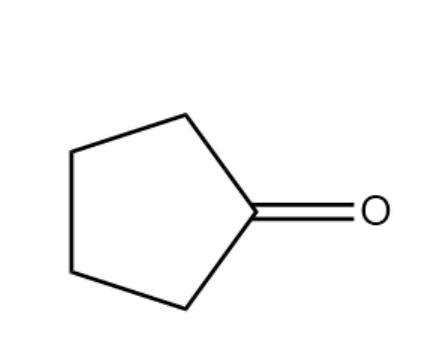

In [18]:
# make index and type_list of element
unique_element_list = np.unique(element_list)
Num_element = unique_element_list.size

element_index_in_molecule = []
for i_element in range(Num_element):
    new_list = [i for i in range(np.array(element_list).size) if element_list[i] == unique_element_list[i_element]]
    element_index_in_molecule.append(new_list)
    
type_list = []
for i_type in range(np.array(element_list).size):
    j, = np.where(unique_element_list == element_list[i_type])
    type_list.append(j[0])

print(type_list)

[0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1]


In [19]:
## symmetric_haparm list

def random_hparam(Num_hparams,Num_atomtype,Range_hparam=[[0.1,4.0],[0.0,4.0],[0.1,4.0],[6,8]]):
    symmetric_hparam=[]
    Num_hparam=len(Range_hparam)
    Delta_hpara=np.zeros(Num_hparam)
    for num_hpara_i in range(Num_hparam):
        Delta_hpara[num_hpara_i] = Range_hparam[num_hpara_i][1]-Range_hparam[num_hpara_i][0]
    #print(Delta_hpara)
        
    for Hparams_i in range(Num_hparams):
        tem_np_hparam=np.zeros((Num_atomtype,Num_hparam))
        for Atomtype_j in range(Num_atomtype):
            for Num_hpara_k in range(Num_hparam):
                tem_np_hparam[Atomtype_j,Num_hpara_k]=random.random()*Delta_hpara[Num_hpara_k]+Range_hparam[Num_hpara_k][0]
        symmetric_hparam.append(tem_np_hparam)
    symmetric_hparam.append('stationary')
    return symmetric_hparam

cba= 0.52917724
wcba = (1/cba)**2
'''
# random generate hparam
symmetric_hparam=random_hparam(Num_hparams=100,Num_atomtype=Num_element,Range_hparam=[[0.1,4.0],[0.0,4.0],[0.1,4.0],[6,8]])

Num_feature = 3*(len(symmetric_hparam)-1)+1
'''

#joint hparam
symmetric_hparam1=[ [0.4*wcba, 0.0, 0.2*wcba, 6.0],
                   [0.1*wcba, 0.0, 0.8*wcba, 6.0],
                   [0.4*wcba, 0.0, 0.4*wcba, 6.0] ]   #geta, g1rs, g2zeta, rc  #给错了参数 应该0.2 0.4 0.8
symmetric_hparam2=[ [0.6*wcba, 0.0, 0.3*wcba, 6.0],
                   [0.2*wcba, 0.0, 1.2*wcba, 6.0],
                   [0.6*wcba, 0.0, 0.6*wcba, 6.0] ]   #geta, g1rs, g2zeta, rc
symmetric_hparam3=[ [0.8*wcba, 0.0, 0.4*wcba, 6.0], #0.4 to 1.0
                   [0.2*wcba, 0.0, 1.6*wcba, 6.0],
                   [0.8*wcba, 0.0, 0.8*wcba, 6] ]   #geta, g1rs, g2zeta, rc

symmetric_hparam=[symmetric_hparam1,symmetric_hparam2,symmetric_hparam3,'stationary']
Num_feature = 2*(len(symmetric_hparam)-1)+1 # one G1 and one G2 per set of hyperparameter and one Gv, with lamda=1 



In [20]:
#read coordinate and energy of each snapshot
def readCxyz(n_files, path, n_atoms):
    '''Read Cartesian coordinates'''
    coord = np.empty([n_files, n_atoms, 3])
    for idx_file in range( n_files ):
        filename = path + str(idx_file+1) + '.xyz'
        fc = open(filename,'r')
        for idx_atom in range(n_atoms):
            line = fc.readline()
            if not line:
               break
            _, coord_x, coord_y, coord_z = line.strip().split()
            coord[idx_file][idx_atom][0] = float(coord_x)
            coord[idx_file][idx_atom][1] = float(coord_y)
            coord[idx_file][idx_atom][2] = float(coord_z)
        fc.close()
    return coord


def readE(n_data, filename):
    ''' Read E '''
    energy = np.empty(n_data)
    e1 = open(filename,'r')
    for idx_data in range( n_data ):
        line = e1.readline()
        if not line:
           break
        energy[idx_data] = float(line.strip().split()[1])
    e1.close()
    return energy


In [21]:
filename_E = 'Energy.dat'
path_xyz='./xyz/'
energy = readE(Num_config, filename_E)
coord = readCxyz(Num_config, path_xyz, Num_atom_all)
print(energy.shape)
print(coord.shape)


(20,)
(20, 14, 3)


In [22]:
filename_E = 'Energy.dat'
path_xyz='./xyz/'
coord = readCxyz(Num_config, path_xyz, Num_atom_all)
energy = readE(Num_config, filename_E)

coord_train, coord_test, energy_train, energy_test = train_test_split(coord, energy, test_size=1 - train_ratio)
coord_valid, coord_test, energy_valid, energy_test = train_test_split(coord_test, energy_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [23]:
#Package parameters to class
class nn_param (object):
    def __init__(self):
        self.geta = None
        self.g1rs = None
        self.g2zeta = None
        self.ctrc = None
        self.Num_atom = None
        self.Num_atom_all = None
        self.Num_conf = None
        self.Lenhparam = None

    def configuration(self, Num_atom, Num_atom_all, Num_conf, type_list, symmetric_hparam):
        self.Num_atom = Num_atom
        self.Num_atom_all = Num_atom_all
        self.Num_conf = Num_conf
        
        
        if symmetric_hparam[-1] =='fixed' or 'stationary':
            self.Lenhparam=len(symmetric_hparam)-1
            self.geta   = np.zeros((self.Num_atom,self.Lenhparam))
            self.g1rs  = np.zeros((self.Num_atom,self.Lenhparam))
            self.g2zeta   = np.zeros((self.Num_atom,self.Lenhparam))
            self.ctrc  = np.zeros((self.Num_atom,self.Lenhparam))
        else:
            print('ERROR:End element of symmetric_hparam should be str type')
        

        for i in range(self.Num_atom):
            for j in range(self.Lenhparam):
                self.geta[i,j]  = symmetric_hparam[j][type_list[i]][0]
                self.g1rs[i,j] = symmetric_hparam[j][type_list[i]][1]
                self.g2zeta[i,j]  = symmetric_hparam[j][type_list[i]][2]
                self.ctrc[i,j] = symmetric_hparam[j][type_list[i]][3]

param_train = nn_param() #all the input parameters in a class
param_valid = nn_param()
param_test  = nn_param()

param_train.configuration(Num_atom, Num_atom_all, Num_train, type_list, symmetric_hparam)
param_valid.configuration(Num_atom, Num_atom_all, Num_valid, type_list, symmetric_hparam)
param_test.configuration(Num_atom, Num_atom_all, Num_test, type_list, symmetric_hparam)


In [24]:
class molecule(object):
    def __init__(self, nn_param):
        self.Num_atom = nn_param.Num_atom
        self.Num_atom_all = nn_param.Num_atom_all
        self.geta = nn_param.geta
        self.g1rs = nn_param.g1rs
        self.g2zeta = nn_param.g2zeta
        self.ctrc = nn_param.ctrc
        self.Len_hparam =nn_param.Lenhparam
        
        self.g1 = np.zeros((self.Num_atom,self.Len_hparam))
        self.g2 = np.zeros((self.Num_atom,self.Len_hparam))
        self.gv = np.zeros((self.Num_atom,1))
    
    def distance(self, r1, r2):
        

        return sqrt((r1[0]-r2[0])*(r1[0]-r2[0]) + (r1[1]-r2[1])*(r1[1]-r2[1]) + (r1[2]-r2[2])*(r1[2]-r2[2])) # x*x is better than x**2 if x<2**30 

    def cosijk(self, d1, d2, d3):

        return (d1*d1 + d3*d3 - d2*d2)/(2 * d1 * d3)
        
    def calc_feature(self, coord, charge_of_water):
        
        #dist
        dist = np.empty([self.Num_atom, self.Num_atom_all])
        for i_atom in range(self.Num_atom):
            for j_atom in range(self.Num_atom_all):
                if j_atom == i_atom:
                    pass
                else:
                    dist[i_atom, j_atom] = self.distance(coord[i_atom, :], coord[j_atom, :])
        #fc
        fc = np.empty([self.Num_atom, self.Num_atom,self.Len_hparam])          
        for n_lenhparam in range(self.Len_hparam):
            for i_atom in range(self.Num_atom):
                for j_atom in range(i_atom+1, self.Num_atom):
                    dist_ij = dist[i_atom, j_atom]
                    if dist_ij <= self.ctrc[i_atom,n_lenhparam]:
                         fc[i_atom, j_atom,n_lenhparam] =  0.5 * ( cos( pi * dist_ij / self.ctrc[i_atom,n_lenhparam] ) + 1 )
                         #fc_tanh[i_atom, j_atom,n_lenhparam]=tanh(tanh(tanh(1-(dist_ij / rc[i_atom,n_lenhparam]))))
                    else:
                        fc[i_atom, j_atom,n_lenhparam] =  0.0
                    fc[j_atom, i_atom,n_lenhparam] = fc[i_atom, j_atom,n_lenhparam]
                    #fc_tanh[j_atom, i_atom,n_lenhparam] = fc_tanh[i_atom, j_atom,n_lenhparam]
        #cal g1
        for n_lenhparam in range(self.Len_hparam):
            for i_atom in range(self.Num_atom):
                for j_atom in range(self.Num_atom):
                    if j_atom == i_atom or (type_list[i_atom]!= 1 and type_list[j_atom]==1):
                        pass
                    else:
                        self.g1[i_atom,n_lenhparam] += exp( -self.geta[i_atom,n_lenhparam] * \
                        ( (dist[i_atom, j_atom] - self.g1rs[i_atom,n_lenhparam])**2 ) )* fc[j_atom, i_atom,n_lenhparam]

                        
                        
        #cal g2
        for n_lenhparam in range(self.Len_hparam):
            for i_atom in range(self.Num_atom):
                for j_atom in range(self.Num_atom):
                    if j_atom == i_atom:
                        pass
                    else:
                        for k_atom in range(self.Num_atom):
                            if k_atom  == j_atom :
                                pass
                            elif k_atom == i_atom:
                                pass
                            elif  type_list[i_atom]!= 1 and (type_list[j_atom]==1 or type_list[k_atom]==1):
                                pass
                            else:
                                #self.g2[i_atom,2*n_lenhparam] += 2**(1-self.g2zeta[i_atom,n_lenhparam])*( ( 1 + self.cosijk( dist[j_atom, k_atom], dist[i_atom, k_atom], dist[i_atom, j_atom] ) )\
                                #**(self.g2zeta[i_atom,n_lenhparam])) *exp( -self.geta[i_atom,n_lenhparam] * ( dist[i_atom, j_atom]**2 + dist[i_atom, k_atom]**2 + dist[i_atom, k_atom]**2) ) \
                                #*fc[j_atom, i_atom,n_lenhparam] * fc[k_atom, i_atom,n_lenhparam] * fc[j_atom, k_atom,n_lenhparam]
                                #self.g2[i_atom,2*n_lenhparam+1] += 2**(1-self.g2zeta[i_atom,n_lenhparam])*( ( 1 - self.cosijk( dist[j_atom, k_atom], dist[i_atom, k_atom], dist[i_atom, j_atom] ) )\
                                #**(self.g2zeta[i_atom,n_lenhparam])) *exp( -self.geta[i_atom,n_lenhparam] * ( dist[i_atom, j_atom]**2 + dist[i_atom, k_atom]**2 + dist[i_atom, k_atom]**2) ) \
                                #*fc[j_atom, i_atom,n_lenhparam] * fc[k_atom, i_atom,n_lenhparam] * fc[j_atom, k_atom,n_lenhparam]
                                self.g2[i_atom,n_lenhparam] += ( ( 1 + self.cosijk( dist[j_atom, k_atom], dist[i_atom, k_atom], dist[i_atom, j_atom] ) )\
                                **(self.g2zeta[i_atom,n_lenhparam])) *exp( -self.geta[i_atom,n_lenhparam] * ( dist[i_atom, j_atom]**2 + dist[i_atom, k_atom]**2 + dist[i_atom, k_atom]**2) ) \
                                *fc[j_atom, i_atom,n_lenhparam] * fc[k_atom, i_atom,n_lenhparam] * fc[j_atom, k_atom,n_lenhparam]

            
        #cal gv
        for i_atom in range(self.Num_atom):
            for j_atom in range(self.Num_atom, self.Num_atom_all):
                if (j_atom - Num_atom) % 3 == 0:
                    self.gv[i_atom,0] += charge_of_water[0]/(dist[i_atom, j_atom]**2)
                else:
                    self.gv[i_atom,0] += charge_of_water[1]/(dist[i_atom, j_atom]**2)                        
                        

In [25]:
snapshots_train = [molecule(param_train) for i_conf in range(Num_train)]
snapshots_valid = [molecule(param_valid) for i_conf in range(Num_valid)]
snapshots_test = [molecule(param_test) for i_conf in range(Num_test)]

for i_conf in range(Num_train):
    snapshots_train[i_conf].calc_feature(coord_train[i_conf,:,:], charge_of_water)
    
for i_conf in range(Num_valid):
    snapshots_valid[i_conf].calc_feature(coord_valid[i_conf,:,:], charge_of_water)
    
for i_conf in range(Num_test):
    snapshots_test[i_conf].calc_feature(coord_test[i_conf,:,:], charge_of_water)

In [26]:
input_feature_train = np.empty(shape=[0, Num_atom * Num_feature])
input_feature_valid = np.empty(shape=[0, Num_atom * Num_feature])
input_feature_test  = np.empty(shape=[0, Num_atom * Num_feature])

for i_conf in range(Num_train):
    input_feature_train = np.append(input_feature_train, [np.concatenate((snapshots_train[i_conf].g1.ravel(), snapshots_train[i_conf].g2.ravel(), snapshots_train[i_conf].gv.ravel()))], axis = 0)
    
for i_conf in range(Num_valid):
    input_feature_valid = np.append(input_feature_valid, [np.concatenate((snapshots_valid[i_conf].g1.ravel(), snapshots_valid[i_conf].g2.ravel(), snapshots_valid[i_conf].gv.ravel()))], axis = 0)
    
for i_conf in range(Num_test):
    input_feature_test = np.append(input_feature_test, [np.concatenate((snapshots_test[i_conf].g1.ravel(), snapshots_test[i_conf].g2.ravel(), snapshots_test[i_conf].gv.ravel()))], axis = 0)


In [34]:
#pytorch tensordataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_train = torch.from_numpy(input_feature_train.astype(np.float32)).to(device)
input_valid = torch.from_numpy(input_feature_valid.astype(np.float32)).to(device)
input_test = torch.from_numpy(input_feature_test.astype(np.float32)).to(device)

output_train = torch.from_numpy(energy_train.astype(np.float32)).to(device)
output_valid = torch.from_numpy(energy_valid.astype(np.float32)).to(device)
output_test = torch.from_numpy(energy_test.astype(np.float32)).to(device)


DLparams = {'batch_size': 40,
            'shuffle': True}

val_DLparams = {'batch_size': Num_valid,
                'shuffle': False}

test_DLparams = {'batch_size': Num_test,
                'shuffle': False}

dataset_train = TensorDataset(input_train, output_train)
dataset_valid = TensorDataset(input_valid, output_valid)
dataset_test = TensorDataset(input_test, output_test)
print(input_train.shape) # 98 = 14 * 7=42+42+14
print(input_train[0][:42])
print(input_train[0][42:84])

loader_train = DataLoader(dataset_train, **DLparams)
loader_valid = DataLoader(dataset_valid, **val_DLparams)
loader_test = DataLoader(dataset_test, **test_DLparams)

torch.Size([15, 98])
tensor([0.0515, 0.0096, 0.0019, 0.0985, 0.0238, 0.0059, 1.3599, 0.5888, 0.5888,
        1.3016, 0.5243, 0.5243, 1.1022, 0.4603, 0.4603, 0.0736, 0.0176, 0.0044,
        1.2171, 0.5132, 0.5132, 1.2131, 0.4877, 0.4877, 0.1017, 0.0296, 0.0090,
        0.1219, 0.0345, 0.0101, 0.0471, 0.0083, 0.0015, 1.0289, 0.4875, 0.4875,
        1.2762, 0.5352, 0.5352, 1.3873, 0.5617, 0.5617])
tensor([3.1186e-05, 1.9450e-07, 1.2691e-09, 2.5896e-04, 4.2951e-06, 7.2432e-08,
        1.8045e+00, 3.9796e-01, 9.6839e-01, 1.4992e+00, 2.7423e-01, 6.5548e-01,
        1.0357e+00, 1.5041e-01, 3.7340e-01, 6.3873e-05, 6.1359e-07, 6.2650e-09,
        1.3563e+00, 2.6003e-01, 6.2771e-01, 1.2831e+00, 2.1917e-01, 5.1843e-01,
        1.9776e-04, 3.5158e-06, 6.6535e-08, 4.0969e-04, 8.9954e-06, 2.0513e-07,
        2.3892e-05, 1.3237e-07, 7.6639e-10, 9.2848e-01, 1.8092e-01, 4.4596e-01,
        1.4907e+00, 2.8790e-01, 6.8491e-01, 1.7508e+00, 3.3663e-01, 8.0310e-01])


In [35]:
#training process
class PlNeuralNet(pl.LightningModule):
    def __init__(self, n_net=1,n1=10,Num_atom=14,lr=1.e-2,Num_feature=3):
        super().__init__()
        subnets = []
        for i_net in range(n_net):
            subnet = nn.Sequential(
                nn.Linear(Num_feature, n1),
                nn.Tanh(),
                nn.Linear(n1, n1),
                nn.Tanh(),
                nn.Linear(n1, 1)
            )
            subnets.append(subnet)
            
        self.model = nn.ModuleList(subnets)
        self.learning_rate = lr
        self.Num_feature=Num_feature
        self.Num_atom=Num_atom
        
    def forward(self, x):    
        b_size, n_atom = x.shape
        atomic_E = torch.zeros((b_size, n_atom//self.Num_feature)).to(device)
        for i_atom in range(self.Num_atom):
            i_subnet = type_list[i_atom]
            atomic_E[:,i_atom] = torch.flatten(self.model[i_subnet](x[:,self.Num_feature*i_atom:self.Num_feature*(i_atom+1)]))
        Eout  = torch.sum(atomic_E, axis = 1)
        return Eout



    def training_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        loss = lossfn(z_pred.squeeze(), z)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        lossval = lossfn(z_pred.squeeze(), z)
        self.log('valloss', lossval)
        return lossval
    
    def test_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        losstest = lossfn(z_pred.squeeze(), z)
        self.log('testloss', losstest)
        return losstest
    

    def configure_optimizers(self):
#        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
#        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1.E-5)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.97),
                     'interval': 'epoch',
                     'frequency': 1,
                    }
        return [optimizer] #, [scheduler]

In [36]:
from pytorch_lightning.callbacks import ModelCheckpoint   
num_epochs = 2000
checkpoint_callback = ModelCheckpoint(save_top_k = -1, save_last = False, every_n_epochs = 100)#100 epochs to save once 
csv_logger = pl_loggers.CSVLogger('logs_csv/', flush_logs_every_n_steps = 15)
trainer = pl.Trainer(max_epochs = num_epochs, log_every_n_steps = 15, logger = csv_logger, callbacks = [checkpoint_callback], accelerator = "auto", devices = "auto")

#trainer = pl.Trainer(max_epochs=num_epochs, logger=csv_logger, gpus=1)
n1 = 100
n_net = Num_element
learning_rate = 1.e-2
model = PlNeuralNet(n_net,n1,Num_atom,learning_rate,Num_feature)

trainer.fit(model, loader_train, loader_valid)
trainer.test(dataloaders = loader_test, ckpt_path = 'best')
trainer.validate(dataloaders = loader_valid, ckpt_path = 'best')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | ModuleList | 33.0 K
-------------------------------------
33.0 K    Trainable params
0         Non-trainable params
33.0 K    Total params
0.132     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=15). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Exception ignored in: <function tqdm.__del__ at 0x0000017D447060E0>
Traceback (most recent call last):
  File "C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\std.py", line 1162, in __del__
    self.close()
  File "C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\notebook.py", line 293, in close
    self.disp(close=True, check_delay=False)
AttributeError: 'Tqdm' object has no attribute 'disp'
Restoring states from the checkpoint path at logs_csv/lightning_logs\version_31\check

Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at logs_csv/lightning_logs\version_31\checkpoints\epoch=199-step=200.ckpt
Loaded model weights from checkpoint at logs_csv/lightning_logs\version_31\checkpoints\epoch=199-step=200.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        testloss             5.704234600067139
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         valloss           0.030831443145871162
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valloss': 0.030831443145871162}]

In [37]:
#print NN model parameters
for name, parameters in model.named_parameters():
        #print(name, ':', parameters,'len',parameters.shape)
        print(name, ':len',parameters.shape)

model.0.0.weight :len torch.Size([100, 7])
model.0.0.bias :len torch.Size([100])
model.0.2.weight :len torch.Size([100, 100])
model.0.2.bias :len torch.Size([100])
model.0.4.weight :len torch.Size([1, 100])
model.0.4.bias :len torch.Size([1])
model.1.0.weight :len torch.Size([100, 7])
model.1.0.bias :len torch.Size([100])
model.1.2.weight :len torch.Size([100, 100])
model.1.2.bias :len torch.Size([100])
model.1.4.weight :len torch.Size([1, 100])
model.1.4.bias :len torch.Size([1])
model.2.0.weight :len torch.Size([100, 7])
model.2.0.bias :len torch.Size([100])
model.2.2.weight :len torch.Size([100, 100])
model.2.2.bias :len torch.Size([100])
model.2.4.weight :len torch.Size([1, 100])
model.2.4.bias :len torch.Size([1])


Text(0, 0.5, 'Errors')

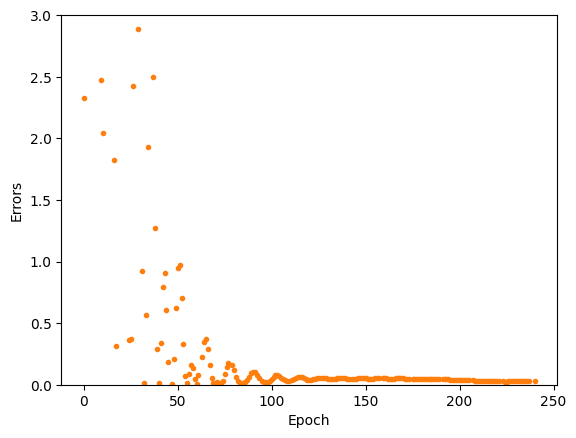

In [38]:
#plot loss curve
import pandas as pd

loss_pack = pd.read_csv("logs_csv/lightning_logs/version_31/metrics.csv")
loss_valid = loss_pack.valloss.dropna()
loss_train = loss_pack.train_loss.dropna()


fig, ax = plt.subplots()
#ax.semilogy(loss_train,'--',loss_valid,'.')
plt.plot(loss_train,'--')
plt.ylim(0,3)
plt.plot(loss_valid,'.')
ax.set_xlabel("Epoch")
ax.set_ylabel("Errors")

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_net = 1, n1 = 10,Num_atom=14,Num_feature=3):  #n1 is the number of neurons for the first layer
        super().__init__()
        subnet = nn.Sequential(
            nn.Linear(Num_feature, n1),
            nn.Tanh(),
            nn.Linear(n1, n1),
            nn.Tanh(),
            nn.Linear(n1, 1)
        )
        subnets = [subnet for i in range(n_net)] 
        self.model = nn.ModuleList(subnets)
        self.Num_feature=Num_feature
        self.Num_atom=Num_atom


    
    def forward(self, x):    
        b_size, n_atom = x.shape
        atomic_E = torch.zeros((b_size, n_atom//self.Num_feature)).to(device)
        for i_atom in range(self.Num_atom):
            i_subnet = type_list[i_atom]
            atomic_E[:,i_atom] = torch.flatten(self.model[i_subnet](x[:,self.Num_feature*i_atom:self.Num_feature*(i_atom+1)]))
        Eout  =torch.sum(atomic_E, axis = 1)
        return Eout

    

def train_loop(dataloader, model, lossfn, optimizer, i_epoch):
    size = len(dataloader.dataset)
    for batch, (input_feature, target) in enumerate(dataloader):
        pred = model(input_feature)   # call model.forward()
        loss = lossfn(pred.squeeze(), target)
    
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch+1 == ceil(len(dataloader.dataset)/DLparams['batch_size']) and i_epoch % 20 == 0:
            loss, current = loss.item(), batch * len(input_feature)
            print(f"epoch: {i_epoch:>4d} loss: {loss:>7.3f}  [{current:>5d}/{size:>5d}]")

In [17]:
# Training of Machine Learning Model without pytorch-lighting
learning_rate = 1e-3
num_epochs = 2000
n_net = Num_element
n1 = 10 
model = NeuralNetwork(n_net, n1,Num_atom,Num_feature).to(device)
lossfn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1.E-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.97)

for i_epoch in range(num_epochs):
    train_loop(loader_train, model, lossfn, optimizer, i_epoch)
    scheduler.step()
    
print("Done with Training!")

epoch:    0 loss:   6.167  [  540/  750]
epoch:   20 loss:   2.986  [  540/  750]
epoch:   40 loss:   4.578  [  540/  750]
epoch:   60 loss:   4.244  [  540/  750]
epoch:   80 loss:   4.314  [  540/  750]
epoch:  100 loss:   4.312  [  540/  750]
epoch:  120 loss:   5.027  [  540/  750]
epoch:  140 loss:   3.815  [  540/  750]
epoch:  160 loss:   5.614  [  540/  750]
epoch:  180 loss:   3.952  [  540/  750]
epoch:  200 loss:   4.156  [  540/  750]
epoch:  220 loss:   2.648  [  540/  750]
epoch:  240 loss:   3.274  [  540/  750]
epoch:  260 loss:   4.335  [  540/  750]
epoch:  280 loss:   3.649  [  540/  750]
epoch:  300 loss:   2.419  [  540/  750]
epoch:  320 loss:   4.724  [  540/  750]
epoch:  340 loss:   3.331  [  540/  750]
epoch:  360 loss:   3.788  [  540/  750]
epoch:  380 loss:   4.208  [  540/  750]
epoch:  400 loss:   2.818  [  540/  750]
epoch:  420 loss:   6.263  [  540/  750]
epoch:  440 loss:   4.123  [  540/  750]
epoch:  460 loss:   4.383  [  540/  750]
epoch:  480 loss